# Posterior inference on a simple birth-death model

In [26]:
from gcdyn import models, mutators, poisson, utils
from scipy.stats import gamma, lognorm
from functools import partial
import numpy as np
import seaborn as sns
from mcmc import mh_step, mh_tour
from jax import jit, disable_jit
from jax.config import config
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm
import pickle

config.update("jax_enable_x64", True)

In [27]:
true_parameters = {
    "birth_response": poisson.ConstantResponse(2),
    "death_response": poisson.ConstantResponse(1),
    "mutation_response": poisson.ConstantResponse(0),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5),
        transition_matrix=utils.random_transition_matrix(length=3),
    ),
    "extant_sampling_probability": 1,
}

PRESENT_TIME = 2

trees = utils.sample_trees(n=5, t=PRESENT_TIME, seed=5, **true_parameters)

for tree in trees:
    tree._pruned = True
# to let σ=1

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 7 times.
Success: average of 37.2 nodes per tree, over 5 trees.


In [29]:
BIRTH_PROPOSAL_SD = 0.2
DEATH_PROPOSAL_SD = 0.2

BIRTH_PRIOR_SHAPE = 2
BIRTH_PRIOR_RATE = 3

DEATH_PRIOR_SHAPE = 3.5
DEATH_PRIOR_RATE = 3

prior_log_densities = {
    "birth_response": lambda response: gamma(
        a=BIRTH_PRIOR_SHAPE, scale=1 / BIRTH_PRIOR_RATE
    ).logpdf(response.value),
    "death_response": lambda response: gamma(
        a=BIRTH_PRIOR_SHAPE, scale=1 / DEATH_PRIOR_RATE
    ).logpdf(response.value),
}

proposal_generators = {
    "birth_response": lambda current: poisson.ConstantResponse(
        lognorm(scale=current.value, s=BIRTH_PROPOSAL_SD).rvs(size=1).item()
    ),
    "death_response": lambda current: poisson.ConstantResponse(
        lognorm(scale=current.value, s=DEATH_PROPOSAL_SD).rvs(size=1).item()
    ),
}

proposal_log_densities = {
    "birth_response": lambda p, c: lognorm(scale=c.value, s=BIRTH_PROPOSAL_SD).logpdf(
        p.value
    ),
    "death_response": lambda p, c: lognorm(scale=c.value, s=DEATH_PROPOSAL_SD).logpdf(
        p.value
    ),
}


log_likelihood = jit(
    partial(
        models.stadler_full_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=1,
        present_time=PRESENT_TIME,
    )
)

In [30]:
samples = mh_tour(
    num_samples=5000,
    initial_value={
        "birth_response": poisson.ConstantResponse(1),
        "death_response": poisson.ConstantResponse(2),
    },
    log_priors=prior_log_densities,
    log_likelihood=log_likelihood,
    proposal_generators=proposal_generators,
    proposal_log_densities=proposal_log_densities,
)

samples = {
    "birth_response": np.hstack([s.value for s in samples["birth_response"]]),
    "death_response": np.hstack([s.value for s in samples["death_response"]]),
}

  0%|          | 0/5000 [00:00<?, ?it/s]

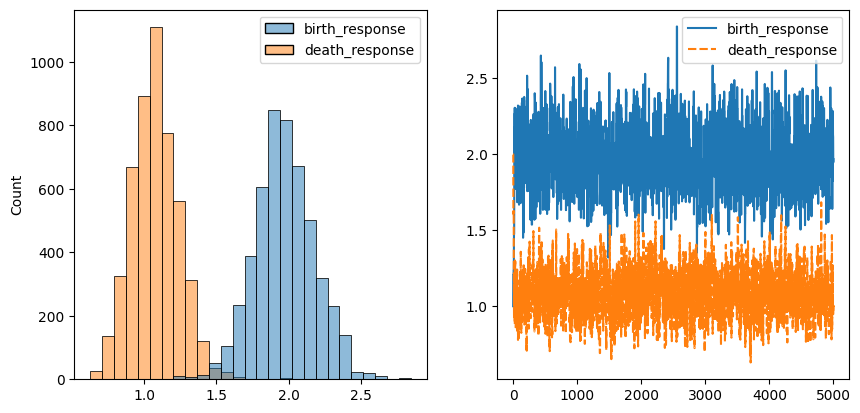

In [31]:
fig, axes = plt.subplots(1, 2)
sns.histplot(samples, ax=axes[0])
sns.lineplot(samples, ax=axes[1])
fig.set_figwidth(10)
plt.show()

In [32]:
acceptance_ratio_birth = np.mean(
    samples["birth_response"][:-1] != samples["birth_response"][1:]
)
acceptance_ratio_death = np.mean(
    samples["death_response"][:-1] != samples["death_response"][1:]
)

print(f"Accepted {acceptance_ratio_birth*100}% of birth response proposals")
print(f"Accepted {acceptance_ratio_death*100}% of death response proposals")

Accepted 51.76% of birth response proposals
Accepted 59.38% of death response proposals
